In [1]:
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import model_bs as mdl
import data_utils as du
import dataset as ds

token_to_idx, idx_to_token = du.load_or_create_vocabulary(csv_paths=[], cache_path="/home/md_halim_mondol/LSTM_VAE_Paper/vocab.json",test_smiles=None)

assert token_to_idx["<PAD>"] == 0
assert token_to_idx["<SOS>"] == 2
assert token_to_idx["<EOS>"] == 3

model = mdl.LSTM_VAE_Trans(
        vocab_size=len(token_to_idx),
        d_model=256,
        latent_dim=64,
        pad_idx=0,
        sos_idx=2,
        eos_idx=3,
        enc_layers=7,
        dec_layers=7,
        nhead=8,
        dropout=0.05,
        max_len=160,
        dim_feedforward=1024)
model.load_state_dict(torch.load("/home/md_halim_mondol/LSTM_VAE_Paper/checkpoints/best_model.pth", map_location="cpu"))

# unwrap DataParallel if needed, and get device
m = model.module if isinstance(model, nn.DataParallel) else model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
m = model  # (no DP wrapping here)
m.eval()

[vocab] loaded cached vocabulary from /home/md_halim_mondol/LSTM_VAE_Paper/vocab.json (69 tokens)


/var/tmp/ipykernel_25025/1521643811.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/md_halim_mondol/LSTM_VAE_Paper/checkpoints/b

LSTM_VAE_Trans(
  (encoder): EncoderBiLSTM(
    (emb): Embedding(69, 256, padding_idx=0)
    (emb_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (emb_do): Dropout(p=0.1, inplace=False)
    (lstm): LSTM(256, 128, num_layers=7, batch_first=True, dropout=0.05, bidirectional=True)
    (out_do): Dropout(p=0.05, inplace=False)
    (seq_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pool_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (to_mu): Linear(in_features=256, out_features=64, bias=True)
  (to_logvar): Linear(in_features=256, out_features=64, bias=True)
  (latent_to_token): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (emb): Embedding(69, 256, padding_idx=0)
    (emb_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0.05, inplace=False)
    )

In [2]:
# Example configuration dictionary
cfg = {"test_files": ["/home/md_halim_mondol/Data/union.csv"], "seq_length": 160, "latent_dim": 64}
smiles = du.load_smiles_list([cfg["test_files"][0]], n_samples=18000, shuffle=False)
test_ds = ds.SMILESDataset(smiles, seq_length=cfg["seq_length"], token_to_idx=token_to_idx,augmentor=None, augment_train=False)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

In [3]:
latents = []
with torch.no_grad():
    for inp, tgt in test_dl:                 # dataset returns (seq, seq)
        inp, tgt = inp.to(device), tgt.to(device)
        # forward with TF returns (logits, mu, logvar)
        _, mu, _ = m(inp, tgt=tgt, teacher_forcing=True)
        latents.append(mu.cpu().numpy())

Z = np.concatenate(latents, axis=0)          # [N, latent_dim]
print("Latents shape:", Z.shape)

/home/md_halim_mondol/anaconda3/envs/cheminf/lib/python3.10/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Latents shape: (18000, 64)


In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, QED
import numpy as np
import pandas as pd

def props_from_smiles(s):
    m = Chem.MolFromSmiles(s)
    if m is None:
        return None
    return dict(
        MW=Descriptors.MolWt(m),
        LogP=Descriptors.MolLogP(m),
        TPSA=rdMolDescriptors.CalcTPSA(m),
        HBA=rdMolDescriptors.CalcNumHBA(m),
        HBD=rdMolDescriptors.CalcNumHBD(m),
        AromRings=rdMolDescriptors.CalcNumAromaticRings(m),
        RotBonds=rdMolDescriptors.CalcNumRotatableBonds(m),
        HeavyAtoms=m.GetNumHeavyAtoms(),
        Fsp3=rdMolDescriptors.CalcFractionCSP3(m),
        QED=QED.qed(m),
    )

prop_rows = []
for s in smiles:
    d = props_from_smiles(s)
    prop_rows.append(d)

prop_df = pd.DataFrame(prop_rows)   # may contain NaNs if SMILES invalid
from IPython.display import display

with pd.option_context("display.max_columns", None, "display.width", None):
    display(prop_df.head())


,MW,LogP,TPSA,HBA,HBD,AromRings,RotBonds,HeavyAtoms,Fsp3,QED
0,230.676,1.4199,49.74,3,0,1,0,14,0.125,0.633710
1,468.383,5.0325,85.97,6,1,4,3,34,0.120,0.257875
2,468.383,5.0325,85.97,6,1,4,3,34,0.120,0.257875
3,441.163,6.1178,35.53,3,0,3,0,29,0.050,0.182667
4,481.287,5.7976,100.88,6,2,5,3,33,0.040,0.338062


In [5]:
valid_mask = prop_df.notna().all(axis=1).values
Z_ok = Z[valid_mask]
smiles_ok = [s for s, keep in zip(smiles, valid_mask) if keep]
props_ok = prop_df.loc[valid_mask].reset_index(drop=True)
print("Kept:", len(smiles_ok), "of", len(smiles))

Kept: 18000 of 18000


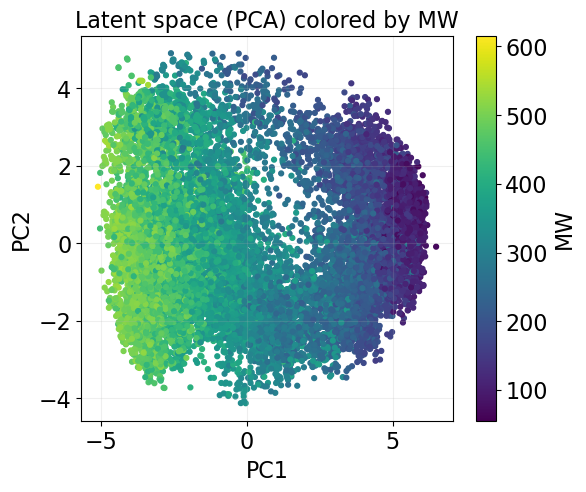

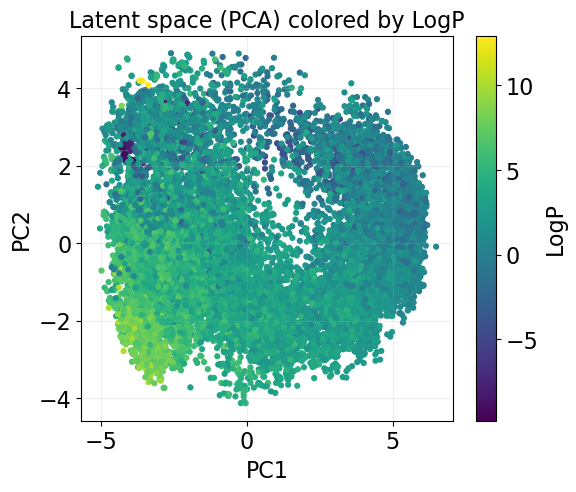

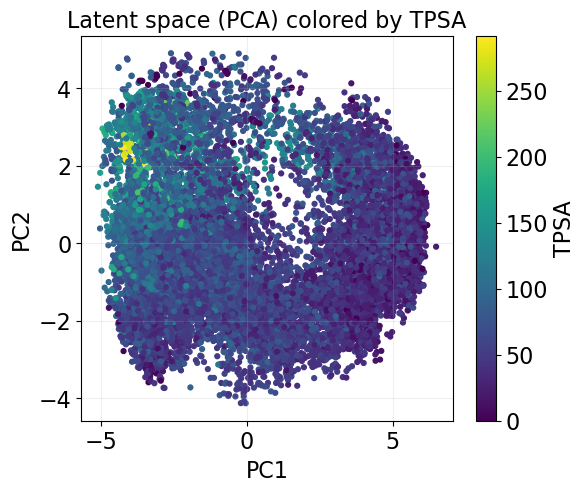

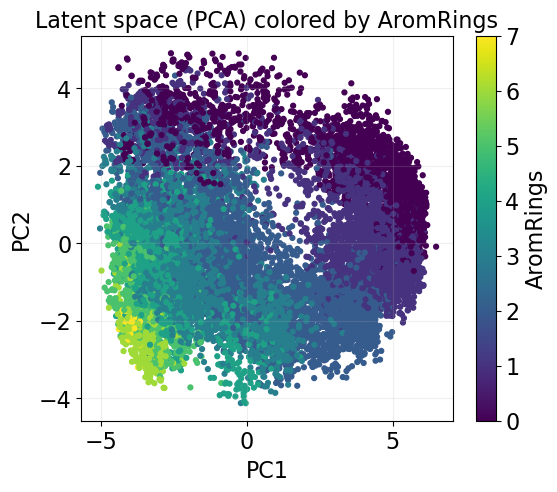

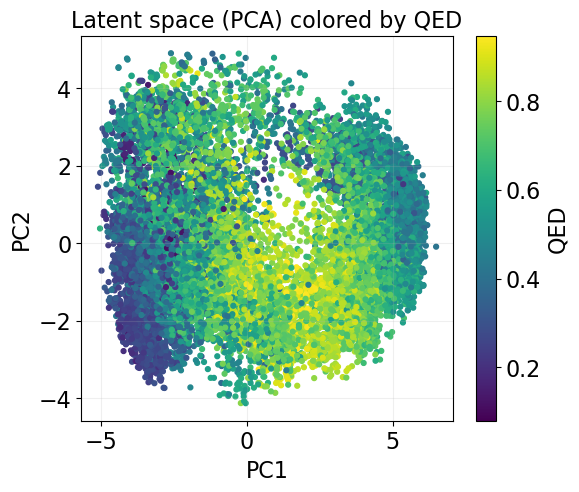

In [6]:
from sklearn.decomposition import PCA
XY = PCA(n_components=2).fit_transform(Z_ok)

def scatter_by(colname):
    fig, ax = plt.subplots(figsize=(6, 5))
    sc = ax.scatter(XY[:, 0], XY[:, 1], c=props_ok[colname].values, s=12, cmap="viridis")

    cbar = fig.colorbar(sc, ax=ax)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label(colname, fontsize=16)

    ax.set_title(f"Latent space (PCA) colored by {colname}", fontsize=16)
    ax.set_xlabel("PC1", fontsize=16)
    ax.set_ylabel("PC2", fontsize=16)
    ax.tick_params(axis="both", labelsize=16)
    ax.grid(alpha=0.2)

    plt.show()


# Try a few:
for col in ["MW", "LogP", "TPSA", "AromRings", "QED"]:
    scatter_by(col)

In [9]:
# ==== Multi-output property head with verbose logging & metrics ====
PROPS = ["AromRings", "MW", "LogP", "Fsp3", "QED"]
LATENT_DIM = Z_ok.shape[1]
CKPT_PATH = "/home/md_halim_mondol/LSTM_VAE_Paper/checkpoints/property_head_best.pt"

import numpy as np, pandas as pd, torch
import torch.nn as nn, torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# 1) Build Y (targets) and one shared split
Y = props_ok[PROPS].values.astype(np.float32)
X_tr, X_va, Y_tr, Y_va = train_test_split(Z_ok, Y, test_size=0.2, random_state=0)

# 2) Standardize X & Y with train stats only
X_mu = X_tr.mean(axis=0, keepdims=True); X_sd = X_tr.std(axis=0, keepdims=True) + 1e-8
Y_mu = Y_tr.mean(axis=0, keepdims=True); Y_sd = Y_tr.std(axis=0, keepdims=True) + 1e-8
Xtr = (X_tr - X_mu) / X_sd; Xva = (X_va - X_mu) / X_sd
Ytr = (Y_tr - Y_mu) / Y_sd; Yva = (Y_va - Y_mu) / Y_sd

Xt = torch.tensor(Xtr, dtype=torch.float32, device=device)
Xv = torch.tensor(Xva, dtype=torch.float32, device=device)
Yt = torch.tensor(Ytr, dtype=torch.float32, device=device)
Yv = torch.tensor(Yva, dtype=torch.float32, device=device)

# 3) Model
class PropertyHead(nn.Module):
    def __init__(self, in_dim, hidden1=128, hidden2=64, out_dim=5, p_drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden1), nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(hidden1, hidden2), nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(hidden2, out_dim),
        )
    def forward(self, x): return self.net(x)

prop_head = PropertyHead(LATENT_DIM, out_dim=len(PROPS)).to(device)

opt = optim.AdamW(prop_head.parameters(), lr=3e-3, weight_decay=2e-4)
loss_fn = nn.MSELoss()

EPOCHS = 1000
patience = 50
print_every = 25

best_val = float("inf")
best_state = None
epochs_no_improve = 0

print(f"Training property head for {EPOCHS} epochs (early stop patience={patience})")
for ep in range(1, EPOCHS + 1):
    # Train
    prop_head.train()
    opt.zero_grad()
    pred_tr = prop_head(Xt)
    loss_tr = loss_fn(pred_tr, Yt)
    loss_tr.backward()
    opt.step()

    # Validate
    prop_head.eval()
    with torch.no_grad():
        pred_va = prop_head(Xv)
        loss_va = loss_fn(pred_va, Yv).item()

    # Track best
    if loss_va < best_val - 1e-7:
        best_val = loss_va
        epochs_no_improve = 0
        best_state = {k: v.detach().cpu().clone() for k, v in prop_head.state_dict().items()}
    else:
        epochs_no_improve += 1

    # Logging
    if ep % print_every == 0 or ep == 1:
        print(f"[{ep:04d}] train MSE: {loss_tr.item():.6f} | val MSE: {loss_va:.6f} | best: {best_val:.6f}")

    # Early stop
    if epochs_no_improve >= patience:
        print(f"[Early stop] at epoch {ep}. Best val MSE: {best_val:.6f}")
        break

# Restore best weights
if best_state is not None:
    prop_head.load_state_dict(best_state)

# 4) Final validation metrics per property (in original units)
prop_head.eval()
with torch.no_grad():
    yv_std = prop_head(Xv).cpu().numpy()           # standardized predictions
yv_pred = yv_std * Y_sd + Y_mu                     # de-standardize
yva_true = Y_va                                    # already in original units

per_prop = []
for i, name in enumerate(PROPS):
    mae_i = mean_absolute_error(yva_true[:, i], yv_pred[:, i])
    r2_i  = r2_score(yva_true[:, i], yv_pred[:, i])
    per_prop.append((name, mae_i, r2_i))

metrics_df = pd.DataFrame(per_prop, columns=["property", "MAE", "R2"]).sort_values("R2", ascending=False)
display(metrics_df)

print("Averages →",
      " MAE:", np.mean(metrics_df["MAE"]).round(4),
      " R2:",  np.mean(metrics_df["R2"]).round(4))

# 5) Save checkpoint with metrics & scalers
ckpt = {
    "model_state": prop_head.state_dict(),
    "x_mu": torch.tensor(X_mu, dtype=torch.float32),
    "x_sd": torch.tensor(X_sd, dtype=torch.float32),
    "y_mu": torch.tensor(Y_mu, dtype=torch.float32),
    "y_sd": torch.tensor(Y_sd, dtype=torch.float32),
    "props": PROPS,
    "latent_dim": LATENT_DIM,
    "arch": {"hidden1": 128, "hidden2": 64, "p_drop": 0.1},
    "best_val_mse_stdspace": float(best_val),  # in standardized Y-space
    "val_metrics": {k: {"MAE": float(mae), "R2": float(r2)} for k, mae, r2 in per_prop},
}
torch.save(ckpt, CKPT_PATH)
print(f"Saved best property head + scalers + metrics to:\n  {CKPT_PATH}")

Training property head for 1000 epochs (early stop patience=50)
[0001] train MSE: 0.991619 | val MSE: 0.928775 | best: 0.928775
[0025] train MSE: 0.207295 | val MSE: 0.171814 | best: 0.171814
[0050] train MSE: 0.140492 | val MSE: 0.113946 | best: 0.113946
[0075] train MSE: 0.117661 | val MSE: 0.094263 | best: 0.094263
[0100] train MSE: 0.105254 | val MSE: 0.083952 | best: 0.083952
[0125] train MSE: 0.096833 | val MSE: 0.077164 | best: 0.077164
[0150] train MSE: 0.090949 | val MSE: 0.072042 | best: 0.072042
[0175] train MSE: 0.085187 | val MSE: 0.067944 | best: 0.067944
[0200] train MSE: 0.081048 | val MSE: 0.065050 | best: 0.064921
[0225] train MSE: 0.078661 | val MSE: 0.062473 | best: 0.062473
[0250] train MSE: 0.075540 | val MSE: 0.060730 | best: 0.060730
[0275] train MSE: 0.073039 | val MSE: 0.058997 | best: 0.058997
[0300] train MSE: 0.070750 | val MSE: 0.057439 | best: 0.057439
[0325] train MSE: 0.069569 | val MSE: 0.056209 | best: 0.056209
[0350] train MSE: 0.067469 | val MSE: 0.

,property,MAE,R2
0,AromRings,0.140162,0.983328
1,MW,14.889103,0.975028
3,Fsp3,0.031140,0.972986
2,LogP,0.505171,0.927100
4,QED,0.040065,0.916425


Averages →  MAE: 3.1211  R2: 0.955
Saved best property head + scalers + metrics to:
  /home/md_halim_mondol/LSTM_VAE_Paper/checkpoints/property_head_best.pt


In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def load_property_head(ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    props = ckpt["props"]
    latent_dim = ckpt["latent_dim"]
    arch = ckpt.get("arch", {"hidden1": 256, "hidden2": 64, "p_drop": 0.1})

    class PropertyHead(nn.Module):
        def __init__(self, in_dim, hidden1=256, hidden2=64, out_dim=5, p_drop=0.05):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, hidden1),
                nn.ReLU(),
                nn.Dropout(p_drop),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Dropout(p_drop),
                nn.Linear(hidden2, out_dim),
            )
        def forward(self, x):
            return self.net(x)

    model = PropertyHead(
        latent_dim,
        hidden1=arch["hidden1"],
        hidden2=arch["hidden2"],
        out_dim=len(props),
        p_drop=arch["p_drop"],
    ).to(device)
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    x_mu = ckpt["x_mu"].to(device)
    x_sd = ckpt["x_sd"].to(device)
    y_mu = ckpt["y_mu"].cpu().numpy()  # for de-standardization on CPU
    y_sd = ckpt["y_sd"].cpu().numpy()
    return model, props, x_mu, x_sd, y_mu, y_sd

def predict_properties(model, props, x_mu, x_sd, y_mu, y_sd, Z_batch, device):
    """
    Z_batch: np.ndarray or torch.Tensor of shape (B, latent_dim)
    Returns: pandas.DataFrame with columns `props`
    """
    if isinstance(Z_batch, np.ndarray):
        Z_batch = torch.tensor(Z_batch, dtype=torch.float32, device=device)
    else:
        Z_batch = Z_batch.to(device).float()

    # standardize X
    Zs = (Z_batch - x_mu) / x_sd

    with torch.no_grad():
        yhat_std = model(Zs).cpu().numpy()  # standardized predictions

    # de-standardize back to original property scales
    yhat = yhat_std * y_sd + y_mu
    return pd.DataFrame(yhat, columns=props)

# --- Usage example ---
# Load the head
model_head, props_list, x_mu, x_sd, y_mu, y_sd = load_property_head(CKPT_PATH, device)

# Predict for, say, the first 10 molecules' latents
pred_df = predict_properties(model_head, props_list, x_mu, x_sd, y_mu, y_sd, Z_ok[:10], device)
display(pred_df)

/var/tmp/ipykernel_25025/4176067643.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


,AromRings,MW,LogP,Fsp3,QED
0,1.252969,232.988983,1.660553,0.149012,0.676199
1,3.706368,467.543884,4.613819,0.152136,0.326691
2,3.723774,471.557373,4.897142,0.145891,0.331240
3,3.225731,472.651489,6.572820,0.104478,0.257372
4,4.915087,477.036682,5.038528,0.037316,0.361804
5,4.951868,460.475647,3.832326,0.111374,0.375950
6,3.072599,409.325806,4.864440,0.132290,0.559574
7,4.694724,426.968079,2.783104,0.019456,0.477641
8,1.975242,244.762543,1.153130,-0.023695,0.696377
9,3.749588,464.202911,4.517733,0.129505,0.311675
